# Synthetic Charged Particle Radiographs with a Wire Mesh

[Tracker]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker

[add_wire_mesh()]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker.add_wire_mesh

In charged particle radiography experiments a wire mesh grid is often placed between the particle source and the object of interest, leaving a shadow of the grid in the particle fluence. The displacement of these shadow grid lines can then be used to quantitatively extract the line-integrated force experienced at each grid vertex.

The [Tracker] class includes a method ([add_wire_mesh()]) that can be used to create synthetic radiographs with a mesh in place. In this example notebook we will illustrate the options available for creating and placing the mesh(s), the demonstrate the use of a mesh grid in a practical example.

In [1]:
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import charged_particle_radiography as cpr
from plasmapy.plasma.grids import CartesianGrid

## Creating and Placing a Wire Mesh

[CartesianGrid]: ../../api/plasmapy.plasma.grids.CartesianGrid.rst#plasmapy.plasma.grids.CartesianGrid

We will begin by creating an empty [CartesianGrid] object in which the electric and magnetic fields are zero. Particle tracing through this grid will allow us to image just the mesh once we add one in place. 

In [2]:
empty_grid = CartesianGrid(-1 * u.mm, 1 * u.mm, num=50)

[Tracker]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker

The charged particle radiography [Tracker] will warn us every time we use this grid that the fields are not specified (before assuming that they are zero). The following line will silence this warning.

In [3]:
warnings.simplefilter("ignore")

We'll also define a fixed source and detector that we won't change for the rest of the example.

In [4]:
source = (0 * u.mm, -10 * u.mm, 0 * u.mm)
detector = (0 * u.mm, 200 * u.mm, 0 * u.mm)

[Tracker]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker


Finally, we'll create an instance of [Tracker].

In [5]:
sim = cpr.Tracker(empty_grid, source, detector, verbose=False)

[Tracker]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker

[add_wire_mesh()]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker.add_wire_mesh

[run()]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker.run

Now it's time to create the mesh. [add_wire_mesh()] takes four required parameters:

- `location` : A vector from the grid origin to the center of the mesh.
- `extent` : The size of the mesh. If two values are given the mesh is assumed to be rectangular (extent is the width, height), but if only one is provided the mesh is assumed to be circular (extent is the diameter).
- `nwires` : The number of wires in each direction. If only one value is given, it's assumed to be the same for both directions.
- `wire_diameter` : The diameter of each wire.

[add_wire_mesh()] works by extrapolating the positions of the particles in the mesh plane (based on their initial velocities) and removing those particles that will hit the wires. When [add_wire_mesh()] is called, the description of the mesh is stored inside the [Tracker] object. Multiple meshes can be added. The particles are then removed when the [run()] method is called.

In [6]:
location = np.array([0, -2, 0]) * u.mm
extent = (1 * u.mm, 1 * u.mm)
nwires = (9, 12)
wire_diameter = 20 * u.um
sim.add_wire_mesh(location, extent, nwires, wire_diameter)

Now that the mesh has been created, we will run the particle tracing simulation and create a synthetic radiograph to visualize the result. We'll wrap this in a function so we can use it again later.

In [7]:
def run_radiograph(sim, vmax=None):
    sim.create_particles(1e5, 15 * u.MeV, max_theta=8 * u.deg)
    sim.run(field_weighting="nearest neighbor")
    h, v, i = cpr.synthetic_radiograph(
        sim, size=np.array([[-1, 1], [-1, 1]]) * 1.8 * u.cm, bins=[200, 200]
    )

    if vmax is None:
        vmax = np.max(i)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pcolormesh(h.to(u.mm).value, v.to(u.mm).value, i.T, cmap="Blues_r", vmax=vmax)
    ax.set_aspect("equal")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")

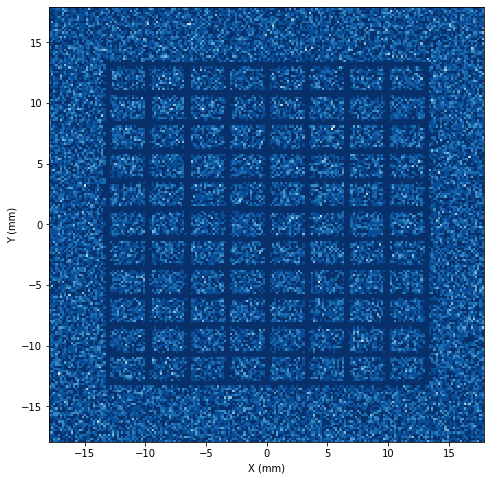

In [8]:
run_radiograph(sim)

Notice that the distance from the source to the mesh is $10 - 2 = 8$ mm, while the distance from the mesh to the detector is $200 + 2 = 202$ mm. The magnification is therefore $M = 1 + 202/8 = 26.25$, so the $1$ mm wide mesh is $26.25$ mm wide in the image.

Changing the `location` keyword can change both the magnification and shift the mesh center.

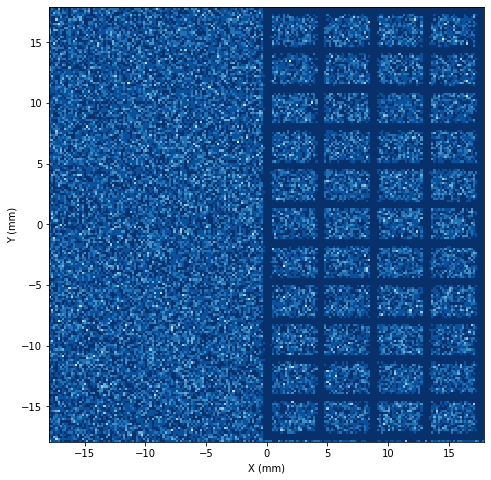

In [9]:
sim = cpr.Tracker(empty_grid, source, detector, verbose=False)
sim.add_wire_mesh(np.array([0.5, -4, 0]) * u.mm, extent, nwires, wire_diameter)
run_radiograph(sim)

Setting the `extent` keyword to a single value will create a circular mesh (with a rectangular grid of wires).

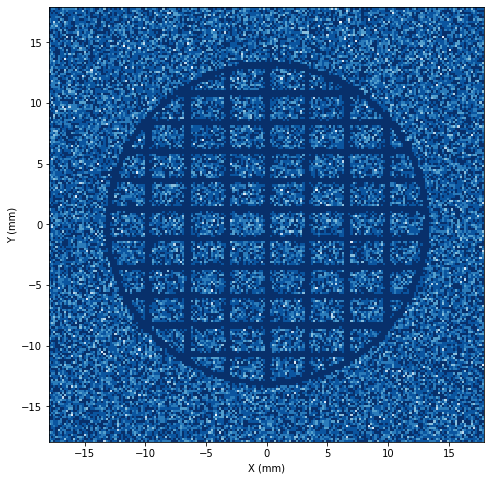

In [10]:
sim = cpr.Tracker(empty_grid, source, detector, verbose=False)
sim.add_wire_mesh(location, (1 * u.mm), nwires, wire_diameter)
run_radiograph(sim)

[add_wire_mesh()]: ../../api/plasmapy.diagnostics.charged_particle_radiography.Tracker.rst#plasmapy.diagnostics.charged_particle_radiography.Tracker.add_wire_mesh

[add_wire_mesh()] has two optional keywords that can be used to change the orientation of the mesh. The first, `mesh_hdir` is a unit vector that sets the horizontal direction of the mesh plane. This can be used to effectively rotate the mesh. For example the following example will rotate the mesh by $45^\circ$ (note that these unit vector inputs are automatically normalized).

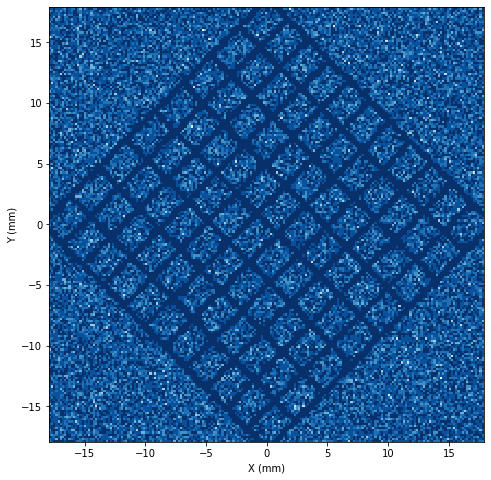

In [11]:
sim = cpr.Tracker(empty_grid, source, detector, verbose=False)
nremoved = sim.add_wire_mesh(
    location, extent, nwires, wire_diameter, mesh_hdir=np.array([0.5, 0, 0.5])
)
run_radiograph(sim)

The second keyword argument, `mesh_vdir`, overrides the unit vector that defines the vertical direction of the mesh plane. By default this vector is set to be mutually orthogonal to `mesh_hdir` and the detector plane normal so that the mesh is parallel to the detector plane. Changing this keyword (alone or in combination with `mesh_hdir`) can be used to create a tilted mesh.

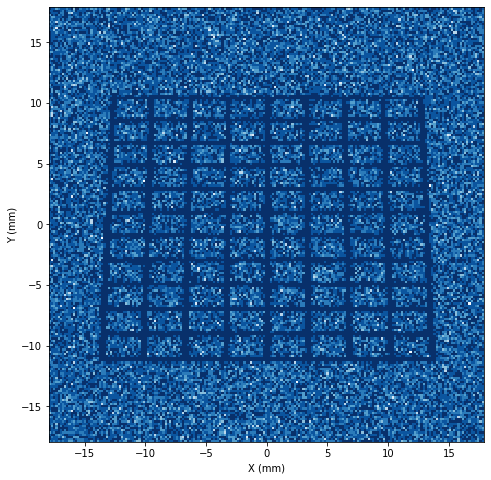

In [12]:
sim = cpr.Tracker(empty_grid, source, detector, verbose=False)
nremoved = sim.add_wire_mesh(
    location, extent, nwires, wire_diameter, mesh_vdir=np.array([0, 0.7, 1])
)
run_radiograph(sim)

## Using a Wire Mesh in an Example Radiograph

[CartesianGrid]: ../../api/plasmapy.plasma.grids.CartesianGrid.rst#plasmapy.plasma.grids.CartesianGrid

To illustrate the use of a mesh in an actual example, we'll first create an example [CartesianGrid] object and fill it with the analytical electric field produced by a sphere of Gaussian potential.

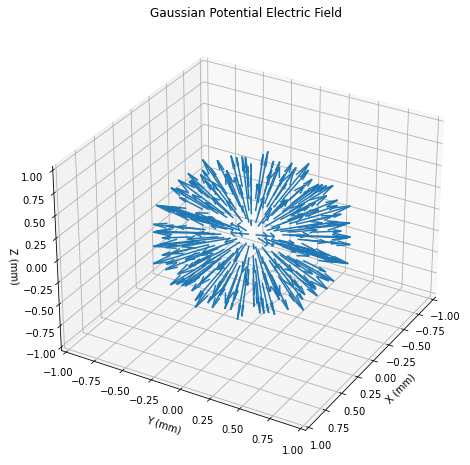

In [13]:
# Create a Cartesian grid
L = 1 * u.mm
grid = CartesianGrid(-L, L, num=150)

# Create a spherical potential with a Gaussian radial distribution
radius = np.linalg.norm(grid.grid, axis=3)
arg = (radius / (L / 3)).to(u.dimensionless_unscaled)
potential = 2e5 * np.exp(-(arg ** 2)) * u.V

# Calculate E from the potential
Ex, Ey, Ez = np.gradient(potential, grid.dax0, grid.dax1, grid.dax2)
Ex = -np.where(radius < L / 2, Ex, 0)
Ey = -np.where(radius < L / 2, Ey, 0)
Ez = -np.where(radius < L / 2, Ez, 0)

# Add those quantities to the grid
grid.add_quantities(E_x=Ex, E_y=Ey, E_z=Ez, phi=potential)


# Plot the E-field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)

# skip some points to make the vector plot intelligable
s = tuple([slice(None, None, 10)] * 3)

ax.quiver(
    grid.pts0[s].to(u.mm).value,
    grid.pts1[s].to(u.mm).value,
    grid.pts2[s].to(u.mm).value,
    grid["E_x"][s],
    grid["E_y"][s],
    grid["E_z"][s],
    length=1e-6,
)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title("Gaussian Potential Electric Field");

Now we will create a mesh and run the particle tracing simulation

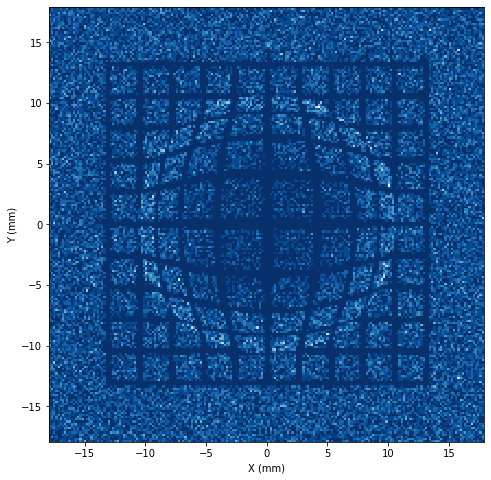

In [14]:
sim = cpr.Tracker(grid, source, detector, verbose=False)
sim.add_wire_mesh(location, extent, 11, wire_diameter)
sim.create_particles(3e5, 15 * u.MeV, max_theta=8 * u.deg)
run_radiograph(sim, vmax=10)

Notice how the vertices of the grid are displaced by the fields.